## Correcting drift in position timeseries


#### Adam Steer, August 2021, adam.d.steer@gmail.com

Sea ice is constantly drifting, so every observation we take on sea ice using GNSS positions needs to be 'drift corrected' in order to show the true spatial relationships between observations. This notebook shows the process of removing drift from airborne camera centre locations, using a reference trajectory from a drifting ice floe.

Operations here are based on code written to translate aircraft trajectories to 'ice floe local' coordinates between 2012 and 2016.

## Required conditions

This process only works if the reference GPS and airborne trajectories overlap in time.


## Steps before running this code

This code requires fairly neatly formatted input files which show a date, timestamp (hh:mm:ss), sometimes a subsecond time field, and X/Y coordinate pairs. A data preparation process is given here, using linux command line tools.

#### Preparing camera centres

Extract camera centre locations and shot timing from images using `exiftool`:

`exiftool -datetimeoriginal -subsectimeoriginal -gpslatitude -gpslongitude -gpsaltitude -abovegroundaltitude -gpsxyaccuracy -gpszaccuracy -camerayawdegree -camerapitchdegree -camerarolldegreee image_dir/*.jpg -c "%.8f" -d "%s" -n -csv > output_filename.csv`

This gets you a CSV file with tabular data showing all the fields given above.

Write out the positions from that CSV file using awk:

`awk -F, '{print $3,$4}' cameracentres.csv > cameralatlons.csv`

Replace the commas in that file with spaces:

`sed -i 's/,/ /g' cameralatlons.csv`

Use `cs2cs` to reproject the lat long pairs to a projected system. This makes it saner to do planar translations later. While the earth is effectively flat at the scales we're using, we should use better maths than we are going to write here to help us out.

`cs2cs -f "%.3f" -r +proj=latlong +datum=WGS84 +to +proj=utm +zone=34 +n +datum=WGS84 cameralatlons.csv > cameraUTM34n.csv`

Next, replace tabs and spaces in the new UTM34 file with commas:

`sed -i 's/\t/,/g' cameraUTM34.csv`
`sed -i 's/ /,/g' cameraUTM34.csv`

Use `head`, a command which previews the head of the file (first 10 lines) to check that all is well. The first line is probably a mess but we can fix that later.

Now we need time. If the camera records subsecond time, we need both `DateTimeOriginal` and `SubSecondTime` from *cameracentres.csv* with `awk`.

`awk -F, '{print $1,$2}' cameracentres.csv > cameratimes.csv`

...then glue times and utm coordinates together:

`pr -m -t -s cameratimes.csv cameraUTM34.csv > utm34-times.csv`

Again, do some tidying - replace tabs and spaces with commas.

`sed -i 's/\t/,/g' utm34-times.csv`
`sed -i 's/ /,/g' utm34-times.csv`

If you got multiple commas or spaces left, iterate a few times with:

`sed -i 's/,,/,/g' utm34-times.csv`

...to remove them (replace commas with any character you want to remove multiples of)

Finally tidy up the first line to something like `date,time,subsecond,easting,northing,height`. Height is 0, but that is fine. Easiest to just leave it there, it has no impact on processing.


### Preparing GPS positions

This process is very similar to preparing camera centres, following the same pattern but missing the exiftool step at the start. It goes:

1. extract lats and lons from a GPS .pos file using awk
2. reproject to UTM using cs2cs
3. extract timestamps from the GPS .pos file using awk
4. use pr to glue times and UTM coordinates together
5. tidy up headers and delimiters

### Preparing magnaprobe positions

....instructions to come

### Preparing GEM2 positions

...instructions to come

At the end of these processes, we should have two files:
1. A comma delimited file of camera centres, magnaprobe points, or gem2 points.
2. A comma delimited file of GPS positions with date, time, easting, northing and height

*Note: camera positions have an extra subsecond time field not present in GEM2 or Magnaprobe data*

At that point, we can start this piece of code!

In [150]:
## import the things

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyproj

In [151]:
## declare useful functions

#perform rotation of an array of 2D coordinates (x,y) about Z axis
def rotate_z(coord, angle):
    r_angle = angle * np.pi/180
    rotmatrix = np.array(((np.cos(r_angle), np.sin(r_angle)), (np.sin(-r_angle), np.cos(r_angle))))
    new_coord = coord * rotmatrix
    return new_coord

def trim_timeseries(t1, t2):
#trim a long timeseries to match a shorter one.
#t1 is the long series, t2 is the short sries
#returns a set of indices to apply to the longer
#timeseries dataset
    start = np.min(t2)-0.5
    end = np.max(t2)+0.5
    idx = (t1>=start)*(t1<=end)
    the_inds = np.where(idx)
    return np.asarray(the_inds), start, end

## this was used for lidar work, but not here - instead we get an exact time match to an image trajectory
def find_nearest_vector(array, value):
#http://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
  idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
  return idx

OK, functions are declared. next is some messy data gathering (maybe implement using Pandas
                                                              to tidy up next time):

In [152]:
# trajectory to adjust, should be 'X Y Z', positions should be in 
traj_dir = '/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/mapping-images/'
trajfile = 'utm34-times.csv'

In [153]:
cameracentres = pd.read_csv(traj_dir + trajfile)

In [154]:
cameracentres

date      time  subsecond     easting     northing  height
0    2021:09:02  10:25:05        707  547235.453  9310856.234     0.0
1    2021:09:02  10:25:14        398  547236.323  9310856.088     0.0
2    2021:09:02  10:25:25        344  547236.932  9310856.093     0.0
3    2021:09:02  10:25:29         11  547236.868  9310855.883     0.0
4    2021:09:02  10:25:32        576  547236.938  9310856.112     0.0
..          ...       ...        ...         ...          ...     ...
310  2021:09:02  11:18:56        452  547292.581  9310978.829     0.0
311  2021:09:02  11:18:59        588  547302.208  9310970.394     0.0
312  2021:09:02  11:19:09        116  547402.543  9310965.422     0.0
313  2021:09:02  11:19:13        698  547451.129  9310968.219     0.0
314  2021:09:02  11:19:16        748  547464.991  9310968.603     0.0

[315 rows x 6 columns]

In [155]:
thetime = cameracentres.time[0]

In [156]:
thetime

'10:25:05'

In [157]:
int(thetime[0:2])*3600

36000

In [158]:
int(thetime[3:5])*60

1500

In [159]:
int(thetime[6:])

5

In [11]:
def getdayseconds(hms, subsecond=None, utc=None):
    
    print(hms)
    if utc is not None:
        hours = int(hms[0:2]) - utc
    else:
        hours = int(hms[0:2])
        
    print(hours)
        
    dayseconds = float(int(hours)*3600.0 + float(hms[3:5])*60.0 + float(hms[6:]))
    
    if subsecond is not None:
        subsecond = int(subsecond)
        if subsecond < 100:
            subsecond = subsecond / 100.0
            dayseconds = dayseconds + subsecond
        elif subsecond >= 100:
            subsecond = subsecond / 1000.0
            dayseconds = dayseconds + subsecond
        
    return dayseconds

In [160]:
getdayseconds(cameracentres.time.values[100], cameracentres.subsecond.values[100], utc=2)

10:35:48
8


30948.483

In [161]:
len(cameracentres.subsecond.values)

315

In [162]:
len(cameracentres.date.values)

315

In [163]:
cameradayseconds = []
for i in np.arange(0,len(cameracentres.time.values)):
    cameradayseconds.append(getdayseconds(cameracentres.time.values[i],cameracentres.subsecond.values[i],2))

10:25:05
8
10:25:14
8
10:25:25
8
10:25:29
8
10:25:32
8
10:25:36
8
10:25:47
8
10:25:51
8
10:25:55
8
10:25:58
8
10:26:13
8
10:26:20
8
10:26:31
8
10:26:34
8
10:26:37
8
10:26:45
8
10:26:52
8
10:26:56
8
10:26:59
8
10:27:02
8
10:27:04
8
10:27:10
8
10:27:15
8
10:27:29
8
10:27:32
8
10:27:50
8
10:27:53
8
10:27:57
8
10:28:07
8
10:28:12
8
10:28:18
8
10:28:27
8
10:28:30
8
10:28:34
8
10:28:45
8
10:28:55
8
10:28:57
8
10:29:02
8
10:29:10
8
10:29:16
8
10:29:22
8
10:29:30
8
10:29:34
8
10:29:41
8
10:29:48
8
10:29:51
8
10:29:55
8
10:29:58
8
10:30:06
8
10:30:20
8
10:30:24
8
10:30:28
8
10:30:31
8
10:30:41
8
10:30:44
8
10:30:55
8
10:31:10
8
10:31:13
8
10:31:16
8
10:31:19
8
10:31:29
8
10:31:33
8
10:31:36
8
10:31:41
8
10:31:51
8
10:31:54
8
10:32:07
8
10:32:13
8
10:32:16
8
10:32:24
8
10:32:29
8
10:32:33
8
10:32:37
8
10:32:50
8
10:32:55
8
10:33:02
8
10:33:06
8
10:33:18
8
10:33:21
8
10:33:25
8
10:33:28
8
10:33:36
8
10:33:40
8
10:33:48
8
10:33:57
8
10:34:03
8
10:34:07
8
10:34:18
8
10:34:36
8
10:34:39
8
10:34:43
8

In [164]:
cameradayseconds = np.array(cameradayseconds)

In [165]:
cameradayseconds[0]

30305.707

In [82]:
# 'correction' trajectory, usually an ice floe fixed GPS
base_dir = '/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/gnss/'
basefile = 'utm34n-times.txt'

In [83]:
basetrajectory = pd.read_csv(base_dir + basefile)

In [84]:
basetrajectory

date             time     easting     northing  height
0      2021/09/02  07:24:14.000000  547290.708  9310773.808     0.0
1      2021/09/02  07:24:14.500000  547289.484  9310773.245     0.0
2      2021/09/02  07:24:15.000000  547289.477  9310773.256     0.0
3      2021/09/02  07:24:15.500000  547289.475  9310773.267     0.0
4      2021/09/02  07:24:16.000000  547289.470  9310773.286     0.0
...           ...              ...         ...          ...     ...
74502  2021/09/02  17:45:05.000000  550913.612  9309874.037     0.0
74503  2021/09/02  17:45:05.500000  550913.651  9309874.044     0.0
74504  2021/09/02  17:45:06.000000  550913.687  9309874.051     0.0
74505  2021/09/02  17:45:06.500000  550913.722  9309874.057     0.0
74506  2021/09/02  17:45:07.000000  550913.757  9309874.060     0.0

[74507 rows x 5 columns]

In [85]:
gpstimes = basetrajectory.time.values

In [86]:
gpstimes[18478]

'09:58:13.000000'

In [87]:
basetrajectory.date[0]

'2021/09/02'

In [88]:
basetrajectory.time[0]

'07:24:14.000000'

In [89]:
cameracentres.date[0]

'2021:09:02'

In [90]:
cameracentres.time[0]

'10:25:05'

In [91]:
basetrajectory.northing[18478]

9311074.519

In [92]:
cameracentres.northing[0] - basetrajectory.northing[18478]

-218.285000000149

In [93]:
gpsdayseconds = []
for i in np.arange(0,len(gpstimes)):
    gpsdayseconds.append(getdayseconds(gpstimes[i]))

07:24:14.000000
7
07:24:14.500000
7
07:24:15.000000
7
07:24:15.500000
7
07:24:16.000000
7
07:24:16.500000
7
07:24:17.000000
7
07:24:17.500000
7
07:24:18.000000
7
07:24:18.500000
7
07:24:19.000000
7
07:24:19.500000
7
07:24:20.000000
7
07:24:20.500000
7
07:24:21.000000
7
07:24:21.500000
7
07:24:22.000000
7
07:24:22.500000
7
07:24:23.000000
7
07:24:23.500000
7
07:24:24.000000
7
07:24:24.500000
7
07:24:25.000000
7
07:24:25.500000
7
07:24:26.000000
7
07:24:26.500000
7
07:24:27.000000
7
07:24:27.500000
7
07:24:28.000000
7
07:24:28.500000
7
07:24:29.000000
7
07:24:29.500000
7
07:24:30.000000
7
07:24:30.500000
7
07:24:31.000000
7
07:24:31.500000
7
07:24:32.000000
7
07:24:32.500000
7
07:24:33.000000
7
07:24:33.500000
7
07:24:34.000000
7
07:24:34.500000
7
07:24:35.000000
7
07:24:35.500000
7
07:24:36.000000
7
07:24:36.500000
7
07:24:37.000000
7
07:24:37.500000
7
07:24:38.000000
7
07:24:38.500000
7
07:24:39.000000
7
07:24:39.500000
7
07:24:40.000000
7
07:24:40.500000
7
07:24:41.000000
7
07:24:41.5

7
07:40:24.500000
7
07:40:25.000000
7
07:40:25.500000
7
07:40:26.000000
7
07:40:26.500000
7
07:40:27.000000
7
07:40:27.500000
7
07:40:28.000000
7
07:40:28.500000
7
07:40:29.000000
7
07:40:29.500000
7
07:40:30.000000
7
07:40:30.500000
7
07:40:31.000000
7
07:40:31.500000
7
07:40:32.000000
7
07:40:32.500000
7
07:40:33.000000
7
07:40:33.500000
7
07:40:34.000000
7
07:40:34.500000
7
07:40:35.000000
7
07:40:35.500000
7
07:40:36.000000
7
07:40:36.500000
7
07:40:37.000000
7
07:40:37.500000
7
07:40:38.000000
7
07:40:38.500000
7
07:40:39.000000
7
07:40:39.500000
7
07:40:40.000000
7
07:40:40.500000
7
07:40:41.000000
7
07:40:41.500000
7
07:40:42.000000
7
07:40:42.500000
7
07:40:43.000000
7
07:40:43.500000
7
07:40:44.000000
7
07:40:44.500000
7
07:40:45.000000
7
07:40:45.500000
7
07:40:46.000000
7
07:40:46.500000
7
07:40:47.000000
7
07:40:47.500000
7
07:40:48.000000
7
07:40:48.500000
7
07:40:49.000000
7
07:40:49.500000
7
07:40:50.000000
7
07:40:50.500000
7
07:40:51.000000
7
07:40:51.500000
7
07:40:52

07:56:12.000000
7
07:56:12.500000
7
07:56:13.000000
7
07:56:13.500000
7
07:56:14.000000
7
07:56:14.500000
7
07:56:15.000000
7
07:56:15.500000
7
07:56:16.000000
7
07:56:16.500000
7
07:56:17.000000
7
07:56:17.500000
7
07:56:18.000000
7
07:56:18.500000
7
07:56:19.000000
7
07:56:19.500000
7
07:56:20.000000
7
07:56:20.500000
7
07:56:21.000000
7
07:56:21.500000
7
07:56:22.000000
7
07:56:22.500000
7
07:56:23.000000
7
07:56:23.500000
7
07:56:24.000000
7
07:56:24.500000
7
07:56:25.000000
7
07:56:25.500000
7
07:56:26.000000
7
07:56:26.500000
7
07:56:27.000000
7
07:56:27.500000
7
07:56:28.000000
7
07:56:28.500000
7
07:56:29.000000
7
07:56:29.500000
7
07:56:30.000000
7
07:56:30.500000
7
07:56:31.000000
7
07:56:31.500000
7
07:56:32.000000
7
07:56:32.500000
7
07:56:33.000000
7
07:56:33.500000
7
07:56:34.000000
7
07:56:34.500000
7
07:56:35.000000
7
07:56:35.500000
7
07:56:36.000000
7
07:56:36.500000
7
07:56:37.000000
7
07:56:37.500000
7
07:56:38.000000
7
07:56:38.500000
7
07:56:39.000000
7
07:56:39.5

8
08:16:01.500000
8
08:16:02.000000
8
08:16:02.500000
8
08:16:03.000000
8
08:16:03.500000
8
08:16:04.000000
8
08:16:04.500000
8
08:16:05.000000
8
08:16:05.500000
8
08:16:06.000000
8
08:16:06.500000
8
08:16:07.000000
8
08:16:07.500000
8
08:16:08.000000
8
08:16:08.500000
8
08:16:09.000000
8
08:16:09.500000
8
08:16:10.000000
8
08:16:10.500000
8
08:16:11.000000
8
08:16:11.500000
8
08:16:12.000000
8
08:16:12.500000
8
08:16:13.000000
8
08:16:13.500000
8
08:16:14.000000
8
08:16:14.500000
8
08:16:15.000000
8
08:16:15.500000
8
08:16:16.000000
8
08:16:16.500000
8
08:16:17.000000
8
08:16:17.500000
8
08:16:18.000000
8
08:16:18.500000
8
08:16:19.000000
8
08:16:19.500000
8
08:16:20.000000
8
08:16:20.500000
8
08:16:21.000000
8
08:16:21.500000
8
08:16:22.000000
8
08:16:22.500000
8
08:16:23.000000
8
08:16:23.500000
8
08:16:24.000000
8
08:16:24.500000
8
08:16:25.000000
8
08:16:25.500000
8
08:16:26.000000
8
08:16:26.500000
8
08:16:27.000000
8
08:16:27.500000
8
08:16:28.000000
8
08:16:28.500000
8
08:16:29

08:39:47.000000
8
08:39:47.500000
8
08:39:48.000000
8
08:39:48.500000
8
08:39:49.000000
8
08:39:49.500000
8
08:39:50.000000
8
08:39:50.500000
8
08:39:51.000000
8
08:39:51.500000
8
08:39:52.000000
8
08:39:52.500000
8
08:39:53.000000
8
08:39:53.500000
8
08:39:54.000000
8
08:39:54.500000
8
08:39:55.000000
8
08:39:55.500000
8
08:39:56.000000
8
08:39:56.500000
8
08:39:57.000000
8
08:39:57.500000
8
08:39:58.000000
8
08:39:58.500000
8
08:39:59.000000
8
08:39:59.500000
8
08:40:00.000000
8
08:40:00.500000
8
08:40:01.000000
8
08:40:01.500000
8
08:40:02.000000
8
08:40:02.500000
8
08:40:03.000000
8
08:40:03.500000
8
08:40:04.000000
8
08:40:04.500000
8
08:40:05.000000
8
08:40:05.500000
8
08:40:06.000000
8
08:40:06.500000
8
08:40:07.000000
8
08:40:07.500000
8
08:40:08.000000
8
08:40:08.500000
8
08:40:09.000000
8
08:40:09.500000
8
08:40:10.000000
8
08:40:10.500000
8
08:40:11.000000
8
08:40:11.500000
8
08:40:12.000000
8
08:40:12.500000
8
08:40:13.000000
8
08:40:13.500000
8
08:40:14.000000
8
08:40:14.5

9
09:04:47.000000
9
09:04:47.500000
9
09:04:48.000000
9
09:04:48.500000
9
09:04:49.000000
9
09:04:49.500000
9
09:04:50.000000
9
09:04:50.500000
9
09:04:51.000000
9
09:04:51.500000
9
09:04:52.000000
9
09:04:52.500000
9
09:04:53.000000
9
09:04:53.500000
9
09:04:54.000000
9
09:04:54.500000
9
09:04:55.000000
9
09:04:55.500000
9
09:04:56.000000
9
09:04:56.500000
9
09:04:57.000000
9
09:04:57.500000
9
09:04:58.000000
9
09:04:58.500000
9
09:04:59.000000
9
09:04:59.500000
9
09:05:00.000000
9
09:05:00.500000
9
09:05:01.000000
9
09:05:01.500000
9
09:05:02.000000
9
09:05:02.500000
9
09:05:03.000000
9
09:05:03.500000
9
09:05:04.000000
9
09:05:04.500000
9
09:05:05.000000
9
09:05:05.500000
9
09:05:06.000000
9
09:05:06.500000
9
09:05:07.000000
9
09:05:07.500000
9
09:05:08.000000
9
09:05:08.500000
9
09:05:09.000000
9
09:05:09.500000
9
09:05:10.000000
9
09:05:10.500000
9
09:05:11.000000
9
09:05:11.500000
9
09:05:12.000000
9
09:05:12.500000
9
09:05:13.000000
9
09:05:13.500000
9
09:05:14.000000
9
09:05:14

09:27:29.000000
9
09:27:29.500000
9
09:27:30.000000
9
09:27:30.500000
9
09:27:31.000000
9
09:27:31.500000
9
09:27:32.000000
9
09:27:32.500000
9
09:27:33.000000
9
09:27:33.500000
9
09:27:34.000000
9
09:27:34.500000
9
09:27:35.000000
9
09:27:35.500000
9
09:27:36.000000
9
09:27:36.500000
9
09:27:37.000000
9
09:27:37.500000
9
09:27:38.000000
9
09:27:38.500000
9
09:27:39.000000
9
09:27:39.500000
9
09:27:40.000000
9
09:27:40.500000
9
09:27:41.000000
9
09:27:41.500000
9
09:27:42.000000
9
09:27:42.500000
9
09:27:43.000000
9
09:27:43.500000
9
09:27:44.000000
9
09:27:44.500000
9
09:27:45.000000
9
09:27:45.500000
9
09:27:46.000000
9
09:27:46.500000
9
09:27:47.000000
9
09:27:47.500000
9
09:27:48.000000
9
09:27:48.500000
9
09:27:49.000000
9
09:27:49.500000
9
09:27:50.000000
9
09:27:50.500000
9
09:27:51.000000
9
09:27:51.500000
9
09:27:52.000000
9
09:27:52.500000
9
09:27:53.000000
9
09:27:53.500000
9
09:27:54.000000
9
09:27:54.500000
9
09:27:55.000000
9
09:27:55.500000
9
09:27:56.000000
9
09:27:56.5

09:51:06.000000
9
09:51:06.500000
9
09:51:07.000000
9
09:51:07.500000
9
09:51:08.000000
9
09:51:08.500000
9
09:51:09.000000
9
09:51:09.500000
9
09:51:10.000000
9
09:51:10.500000
9
09:51:11.000000
9
09:51:11.500000
9
09:51:12.000000
9
09:51:12.500000
9
09:51:13.000000
9
09:51:13.500000
9
09:51:14.000000
9
09:51:14.500000
9
09:51:15.000000
9
09:51:15.500000
9
09:51:16.000000
9
09:51:16.500000
9
09:51:17.000000
9
09:51:17.500000
9
09:51:18.000000
9
09:51:18.500000
9
09:51:19.000000
9
09:51:19.500000
9
09:51:20.000000
9
09:51:20.500000
9
09:51:21.000000
9
09:51:21.500000
9
09:51:22.000000
9
09:51:22.500000
9
09:51:23.000000
9
09:51:23.500000
9
09:51:24.000000
9
09:51:24.500000
9
09:51:25.000000
9
09:51:25.500000
9
09:51:26.000000
9
09:51:26.500000
9
09:51:27.000000
9
09:51:27.500000
9
09:51:28.000000
9
09:51:28.500000
9
09:51:29.000000
9
09:51:29.500000
9
09:51:30.000000
9
09:51:30.500000
9
09:51:31.000000
9
09:51:31.500000
9
09:51:32.000000
9
09:51:32.500000
9
09:51:33.000000
9
09:51:33.5

10
10:09:31.000000
10
10:09:31.500000
10
10:09:32.000000
10
10:09:32.500000
10
10:09:33.000000
10
10:09:33.500000
10
10:09:34.000000
10
10:09:34.500000
10
10:09:35.000000
10
10:09:35.500000
10
10:09:36.000000
10
10:09:36.500000
10
10:09:37.000000
10
10:09:37.500000
10
10:09:38.000000
10
10:09:38.500000
10
10:09:39.000000
10
10:09:39.500000
10
10:09:40.000000
10
10:09:40.500000
10
10:09:41.000000
10
10:09:41.500000
10
10:09:42.000000
10
10:09:42.500000
10
10:09:43.000000
10
10:09:43.500000
10
10:09:44.000000
10
10:09:44.500000
10
10:09:45.000000
10
10:09:45.500000
10
10:09:46.000000
10
10:09:46.500000
10
10:09:47.000000
10
10:09:47.500000
10
10:09:48.000000
10
10:09:48.500000
10
10:09:49.000000
10
10:09:49.500000
10
10:09:50.000000
10
10:09:50.500000
10
10:09:51.000000
10
10:09:51.500000
10
10:09:52.000000
10
10:09:52.500000
10
10:09:53.000000
10
10:09:53.500000
10
10:09:54.000000
10
10:09:54.500000
10
10:09:55.000000
10
10:09:55.500000
10
10:09:56.000000
10
10:09:56.500000
10
10:09:57.

10
10:32:16.500000
10
10:32:17.000000
10
10:32:17.500000
10
10:32:18.000000
10
10:32:18.500000
10
10:32:19.000000
10
10:32:19.500000
10
10:32:20.000000
10
10:32:20.500000
10
10:32:21.000000
10
10:32:21.500000
10
10:32:22.000000
10
10:32:22.500000
10
10:32:23.000000
10
10:32:23.500000
10
10:32:24.000000
10
10:32:24.500000
10
10:32:25.000000
10
10:32:25.500000
10
10:32:26.000000
10
10:32:26.500000
10
10:32:27.000000
10
10:32:27.500000
10
10:32:28.000000
10
10:32:28.500000
10
10:32:29.000000
10
10:32:29.500000
10
10:32:30.000000
10
10:32:30.500000
10
10:32:31.000000
10
10:32:31.500000
10
10:32:32.000000
10
10:32:32.500000
10
10:32:33.000000
10
10:32:33.500000
10
10:32:34.000000
10
10:32:34.500000
10
10:32:35.000000
10
10:32:35.500000
10
10:32:36.000000
10
10:32:36.500000
10
10:32:37.000000
10
10:32:37.500000
10
10:32:38.000000
10
10:32:38.500000
10
10:32:39.000000
10
10:32:39.500000
10
10:32:40.000000
10
10:32:40.500000
10
10:32:41.000000
10
10:32:41.500000
10
10:32:42.000000
10
10:32:42.

10:48:24.000000
10
10:48:24.500000
10
10:48:25.000000
10
10:48:25.500000
10
10:48:26.000000
10
10:48:26.500000
10
10:48:27.000000
10
10:48:27.500000
10
10:48:28.000000
10
10:48:28.500000
10
10:48:29.000000
10
10:48:29.500000
10
10:48:30.000000
10
10:48:30.500000
10
10:48:31.000000
10
10:48:31.500000
10
10:48:32.000000
10
10:48:32.500000
10
10:48:33.000000
10
10:48:33.500000
10
10:48:34.000000
10
10:48:34.500000
10
10:48:35.000000
10
10:48:35.500000
10
10:48:36.000000
10
10:48:36.500000
10
10:48:37.000000
10
10:48:37.500000
10
10:48:38.000000
10
10:48:38.500000
10
10:48:39.000000
10
10:48:39.500000
10
10:48:40.000000
10
10:48:40.500000
10
10:48:41.000000
10
10:48:41.500000
10
10:48:42.000000
10
10:48:42.500000
10
10:48:43.000000
10
10:48:43.500000
10
10:48:44.000000
10
10:48:44.500000
10
10:48:45.000000
10
10:48:45.500000
10
10:48:46.000000
10
10:48:46.500000
10
10:48:47.000000
10
10:48:47.500000
10
10:48:48.000000
10
10:48:48.500000
10
10:48:49.000000
10
10:48:49.500000
10
10:48:50.000

11
11:12:17.500000
11
11:12:18.000000
11
11:12:18.500000
11
11:12:19.000000
11
11:12:19.500000
11
11:12:20.000000
11
11:12:20.500000
11
11:12:21.000000
11
11:12:21.500000
11
11:12:22.000000
11
11:12:22.500000
11
11:12:23.000000
11
11:12:23.500000
11
11:12:24.000000
11
11:12:24.500000
11
11:12:25.000000
11
11:12:25.500000
11
11:12:26.000000
11
11:12:26.500000
11
11:12:27.000000
11
11:12:27.500000
11
11:12:28.000000
11
11:12:28.500000
11
11:12:29.000000
11
11:12:29.500000
11
11:12:30.000000
11
11:12:30.500000
11
11:12:31.000000
11
11:12:31.500000
11
11:12:32.000000
11
11:12:32.500000
11
11:12:33.000000
11
11:12:33.500000
11
11:12:34.000000
11
11:12:34.500000
11
11:12:35.000000
11
11:12:35.500000
11
11:12:36.000000
11
11:12:36.500000
11
11:12:37.000000
11
11:12:37.500000
11
11:12:38.000000
11
11:12:38.500000
11
11:12:39.000000
11
11:12:39.500000
11
11:12:40.000000
11
11:12:40.500000
11
11:12:41.000000
11
11:12:41.500000
11
11:12:42.000000
11
11:12:42.500000
11
11:12:43.000000
11
11:12:43.

11:36:19.000000
11
11:36:19.500000
11
11:36:20.000000
11
11:36:20.500000
11
11:36:21.000000
11
11:36:21.500000
11
11:36:22.000000
11
11:36:22.500000
11
11:36:23.000000
11
11:36:23.500000
11
11:36:24.000000
11
11:36:24.500000
11
11:36:25.000000
11
11:36:25.500000
11
11:36:26.000000
11
11:36:26.500000
11
11:36:27.000000
11
11:36:27.500000
11
11:36:28.000000
11
11:36:28.500000
11
11:36:29.000000
11
11:36:29.500000
11
11:36:30.000000
11
11:36:30.500000
11
11:36:31.000000
11
11:36:31.500000
11
11:36:32.000000
11
11:36:32.500000
11
11:36:33.000000
11
11:36:33.500000
11
11:36:34.000000
11
11:36:34.500000
11
11:36:35.000000
11
11:36:35.500000
11
11:36:36.000000
11
11:36:36.500000
11
11:36:37.000000
11
11:36:37.500000
11
11:36:38.000000
11
11:36:38.500000
11
11:36:39.000000
11
11:36:39.500000
11
11:36:40.000000
11
11:36:40.500000
11
11:36:41.000000
11
11:36:41.500000
11
11:36:42.000000
11
11:36:42.500000
11
11:36:43.000000
11
11:36:43.500000
11
11:36:44.000000
11
11:36:44.500000
11
11:36:45.000

12:00:14.500000
12
12:00:15.000000
12
12:00:15.500000
12
12:00:16.000000
12
12:00:16.500000
12
12:00:17.000000
12
12:00:17.500000
12
12:00:18.000000
12
12:00:18.500000
12
12:00:19.000000
12
12:00:19.500000
12
12:00:20.000000
12
12:00:20.500000
12
12:00:21.000000
12
12:00:21.500000
12
12:00:22.000000
12
12:00:22.500000
12
12:00:23.000000
12
12:00:23.500000
12
12:00:24.000000
12
12:00:24.500000
12
12:00:25.000000
12
12:00:25.500000
12
12:00:26.000000
12
12:00:26.500000
12
12:00:27.000000
12
12:00:27.500000
12
12:00:28.000000
12
12:00:28.500000
12
12:00:29.000000
12
12:00:29.500000
12
12:00:30.000000
12
12:00:30.500000
12
12:00:31.000000
12
12:00:31.500000
12
12:00:32.000000
12
12:00:32.500000
12
12:00:33.000000
12
12:00:33.500000
12
12:00:34.000000
12
12:00:34.500000
12
12:00:35.000000
12
12:00:35.500000
12
12:00:36.000000
12
12:00:36.500000
12
12:00:37.000000
12
12:00:37.500000
12
12:00:38.000000
12
12:00:38.500000
12
12:00:39.000000
12
12:00:39.500000
12
12:00:40.000000
12
12:00:40.500

12:18:58.000000
12
12:18:58.500000
12
12:18:59.000000
12
12:18:59.500000
12
12:19:00.000000
12
12:19:00.500000
12
12:19:01.000000
12
12:19:01.500000
12
12:19:02.000000
12
12:19:02.500000
12
12:19:03.000000
12
12:19:03.500000
12
12:19:04.000000
12
12:19:04.500000
12
12:19:05.000000
12
12:19:05.500000
12
12:19:06.000000
12
12:19:06.500000
12
12:19:07.000000
12
12:19:07.500000
12
12:19:08.000000
12
12:19:08.500000
12
12:19:09.000000
12
12:19:09.500000
12
12:19:10.000000
12
12:19:10.500000
12
12:19:11.000000
12
12:19:11.500000
12
12:19:12.000000
12
12:19:12.500000
12
12:19:13.000000
12
12:19:13.500000
12
12:19:14.000000
12
12:19:14.500000
12
12:19:15.000000
12
12:19:15.500000
12
12:19:16.000000
12
12:19:16.500000
12
12:19:17.000000
12
12:19:17.500000
12
12:19:18.000000
12
12:19:18.500000
12
12:19:19.000000
12
12:19:19.500000
12
12:19:20.000000
12
12:19:20.500000
12
12:19:21.000000
12
12:19:21.500000
12
12:19:22.000000
12
12:19:22.500000
12
12:19:23.000000
12
12:19:23.500000
12
12:19:24.000

12
12:34:47.500000
12
12:34:48.000000
12
12:34:48.500000
12
12:34:49.000000
12
12:34:49.500000
12
12:34:50.000000
12
12:34:50.500000
12
12:34:51.000000
12
12:34:51.500000
12
12:34:52.000000
12
12:34:52.500000
12
12:34:53.000000
12
12:34:53.500000
12
12:34:54.000000
12
12:34:54.500000
12
12:34:55.000000
12
12:34:55.500000
12
12:34:56.000000
12
12:34:56.500000
12
12:34:57.000000
12
12:34:57.500000
12
12:34:58.000000
12
12:34:58.500000
12
12:34:59.000000
12
12:34:59.500000
12
12:35:00.000000
12
12:35:00.500000
12
12:35:01.000000
12
12:35:01.500000
12
12:35:02.000000
12
12:35:02.500000
12
12:35:03.000000
12
12:35:03.500000
12
12:35:04.000000
12
12:35:04.500000
12
12:35:05.000000
12
12:35:05.500000
12
12:35:06.000000
12
12:35:06.500000
12
12:35:07.000000
12
12:35:07.500000
12
12:35:08.000000
12
12:35:08.500000
12
12:35:09.000000
12
12:35:09.500000
12
12:35:10.000000
12
12:35:10.500000
12
12:35:11.000000
12
12:35:11.500000
12
12:35:12.000000
12
12:35:12.500000
12
12:35:13.000000
12
12:35:13.

13:00:10.500000
13
13:00:11.000000
13
13:00:11.500000
13
13:00:12.000000
13
13:00:12.500000
13
13:00:13.000000
13
13:00:13.500000
13
13:00:14.000000
13
13:00:14.500000
13
13:00:15.000000
13
13:00:15.500000
13
13:00:16.000000
13
13:00:16.500000
13
13:00:17.000000
13
13:00:17.500000
13
13:00:18.000000
13
13:00:18.500000
13
13:00:19.000000
13
13:00:19.500000
13
13:00:20.000000
13
13:00:20.500000
13
13:00:21.000000
13
13:00:21.500000
13
13:00:22.000000
13
13:00:22.500000
13
13:00:23.000000
13
13:00:23.500000
13
13:00:24.000000
13
13:00:24.500000
13
13:00:25.000000
13
13:00:25.500000
13
13:00:26.000000
13
13:00:26.500000
13
13:00:27.000000
13
13:00:27.500000
13
13:00:28.000000
13
13:00:28.500000
13
13:00:29.000000
13
13:00:29.500000
13
13:00:30.000000
13
13:00:30.500000
13
13:00:31.000000
13
13:00:31.500000
13
13:00:32.000000
13
13:00:32.500000
13
13:00:33.000000
13
13:00:33.500000
13
13:00:34.000000
13
13:00:34.500000
13
13:00:35.000000
13
13:00:35.500000
13
13:00:36.000000
13
13:00:36.500

13
13:26:12.000000
13
13:26:12.500000
13
13:26:13.000000
13
13:26:13.500000
13
13:26:14.000000
13
13:26:14.500000
13
13:26:15.000000
13
13:26:15.500000
13
13:26:16.000000
13
13:26:16.500000
13
13:26:17.000000
13
13:26:17.500000
13
13:26:18.000000
13
13:26:18.500000
13
13:26:19.000000
13
13:26:19.500000
13
13:26:20.000000
13
13:26:20.500000
13
13:26:21.000000
13
13:26:21.500000
13
13:26:22.000000
13
13:26:22.500000
13
13:26:23.000000
13
13:26:23.500000
13
13:26:24.000000
13
13:26:24.500000
13
13:26:25.000000
13
13:26:25.500000
13
13:26:26.000000
13
13:26:26.500000
13
13:26:27.000000
13
13:26:27.500000
13
13:26:28.000000
13
13:26:28.500000
13
13:26:29.000000
13
13:26:29.500000
13
13:26:30.000000
13
13:26:30.500000
13
13:26:31.000000
13
13:26:31.500000
13
13:26:32.000000
13
13:26:32.500000
13
13:26:33.000000
13
13:26:33.500000
13
13:26:34.000000
13
13:26:34.500000
13
13:26:35.000000
13
13:26:35.500000
13
13:26:36.000000
13
13:26:36.500000
13
13:26:37.000000
13
13:26:37.500000
13
13:26:38.

13:47:00.500000
13
13:47:01.000000
13
13:47:01.500000
13
13:47:02.000000
13
13:47:02.500000
13
13:47:03.000000
13
13:47:03.500000
13
13:47:04.000000
13
13:47:04.500000
13
13:47:05.000000
13
13:47:05.500000
13
13:47:06.000000
13
13:47:06.500000
13
13:47:07.000000
13
13:47:07.500000
13
13:47:08.000000
13
13:47:08.500000
13
13:47:09.000000
13
13:47:09.500000
13
13:47:10.000000
13
13:47:10.500000
13
13:47:11.000000
13
13:47:11.500000
13
13:47:12.000000
13
13:47:12.500000
13
13:47:13.000000
13
13:47:13.500000
13
13:47:14.000000
13
13:47:14.500000
13
13:47:15.000000
13
13:47:15.500000
13
13:47:16.000000
13
13:47:16.500000
13
13:47:17.000000
13
13:47:17.500000
13
13:47:18.000000
13
13:47:18.500000
13
13:47:19.000000
13
13:47:19.500000
13
13:47:20.000000
13
13:47:20.500000
13
13:47:21.000000
13
13:47:21.500000
13
13:47:22.000000
13
13:47:22.500000
13
13:47:23.000000
13
13:47:23.500000
13
13:47:24.000000
13
13:47:24.500000
13
13:47:25.000000
13
13:47:25.500000
13
13:47:26.000000
13
13:47:26.500

14
14:09:58.500000
14
14:09:59.000000
14
14:09:59.500000
14
14:10:00.000000
14
14:10:00.500000
14
14:10:01.000000
14
14:10:01.500000
14
14:10:02.000000
14
14:10:02.500000
14
14:10:03.000000
14
14:10:03.500000
14
14:10:04.000000
14
14:10:04.500000
14
14:10:05.000000
14
14:10:05.500000
14
14:10:06.000000
14
14:10:06.500000
14
14:10:07.000000
14
14:10:07.500000
14
14:10:08.000000
14
14:10:08.500000
14
14:10:09.000000
14
14:10:09.500000
14
14:10:10.000000
14
14:10:10.500000
14
14:10:11.000000
14
14:10:11.500000
14
14:10:12.000000
14
14:10:12.500000
14
14:10:13.000000
14
14:10:13.500000
14
14:10:14.000000
14
14:10:14.500000
14
14:10:15.000000
14
14:10:15.500000
14
14:10:16.000000
14
14:10:16.500000
14
14:10:17.000000
14
14:10:17.500000
14
14:10:18.000000
14
14:10:18.500000
14
14:10:19.000000
14
14:10:19.500000
14
14:10:20.000000
14
14:10:20.500000
14
14:10:21.000000
14
14:10:21.500000
14
14:10:22.000000
14
14:10:22.500000
14
14:10:23.000000
14
14:10:23.500000
14
14:10:24.000000
14
14:10:24.

14:31:16.500000
14
14:31:17.000000
14
14:31:17.500000
14
14:31:18.000000
14
14:31:18.500000
14
14:31:19.000000
14
14:31:19.500000
14
14:31:20.000000
14
14:31:20.500000
14
14:31:21.000000
14
14:31:21.500000
14
14:31:22.000000
14
14:31:22.500000
14
14:31:23.000000
14
14:31:23.500000
14
14:31:24.000000
14
14:31:24.500000
14
14:31:25.000000
14
14:31:25.500000
14
14:31:26.000000
14
14:31:26.500000
14
14:31:27.000000
14
14:31:27.500000
14
14:31:28.000000
14
14:31:28.500000
14
14:31:29.000000
14
14:31:29.500000
14
14:31:30.000000
14
14:31:30.500000
14
14:31:31.000000
14
14:31:31.500000
14
14:31:32.000000
14
14:31:32.500000
14
14:31:33.000000
14
14:31:33.500000
14
14:31:34.000000
14
14:31:34.500000
14
14:31:35.000000
14
14:31:35.500000
14
14:31:36.000000
14
14:31:36.500000
14
14:31:37.000000
14
14:31:37.500000
14
14:31:38.000000
14
14:31:38.500000
14
14:31:39.000000
14
14:31:39.500000
14
14:31:40.000000
14
14:31:40.500000
14
14:31:41.000000
14
14:31:41.500000
14
14:31:42.000000
14
14:31:42.500

14:53:21.000000
14
14:53:21.500000
14
14:53:22.000000
14
14:53:22.500000
14
14:53:23.000000
14
14:53:23.500000
14
14:53:24.000000
14
14:53:24.500000
14
14:53:25.000000
14
14:53:25.500000
14
14:53:26.000000
14
14:53:26.500000
14
14:53:27.000000
14
14:53:27.500000
14
14:53:28.000000
14
14:53:28.500000
14
14:53:29.000000
14
14:53:29.500000
14
14:53:30.000000
14
14:53:30.500000
14
14:53:31.000000
14
14:53:31.500000
14
14:53:32.000000
14
14:53:32.500000
14
14:53:33.000000
14
14:53:33.500000
14
14:53:34.000000
14
14:53:34.500000
14
14:53:35.000000
14
14:53:35.500000
14
14:53:36.000000
14
14:53:36.500000
14
14:53:37.000000
14
14:53:37.500000
14
14:53:38.000000
14
14:53:38.500000
14
14:53:39.000000
14
14:53:39.500000
14
14:53:40.000000
14
14:53:40.500000
14
14:53:41.000000
14
14:53:41.500000
14
14:53:42.000000
14
14:53:42.500000
14
14:53:43.000000
14
14:53:43.500000
14
14:53:44.000000
14
14:53:44.500000
14
14:53:45.000000
14
14:53:45.500000
14
14:53:46.000000
14
14:53:46.500000
14
14:53:47.000

15:15:15.500000
15
15:15:16.000000
15
15:15:16.500000
15
15:15:17.000000
15
15:15:17.500000
15
15:15:18.000000
15
15:15:18.500000
15
15:15:19.000000
15
15:15:19.500000
15
15:15:20.000000
15
15:15:20.500000
15
15:15:21.000000
15
15:15:21.500000
15
15:15:22.000000
15
15:15:22.500000
15
15:15:23.000000
15
15:15:23.500000
15
15:15:24.000000
15
15:15:24.500000
15
15:15:25.000000
15
15:15:25.500000
15
15:15:26.000000
15
15:15:26.500000
15
15:15:27.000000
15
15:15:27.500000
15
15:15:28.000000
15
15:15:28.500000
15
15:15:29.000000
15
15:15:29.500000
15
15:15:30.000000
15
15:15:30.500000
15
15:15:31.000000
15
15:15:31.500000
15
15:15:32.000000
15
15:15:32.500000
15
15:15:33.000000
15
15:15:33.500000
15
15:15:34.000000
15
15:15:34.500000
15
15:15:35.000000
15
15:15:35.500000
15
15:15:36.000000
15
15:15:36.500000
15
15:15:37.000000
15
15:15:37.500000
15
15:15:38.000000
15
15:15:38.500000
15
15:15:39.000000
15
15:15:39.500000
15
15:15:40.000000
15
15:15:40.500000
15
15:15:41.000000
15
15:15:41.500

15
15:33:26.500000
15
15:33:27.000000
15
15:33:27.500000
15
15:33:28.000000
15
15:33:28.500000
15
15:33:29.000000
15
15:33:29.500000
15
15:33:30.000000
15
15:33:30.500000
15
15:33:31.000000
15
15:33:31.500000
15
15:33:32.000000
15
15:33:32.500000
15
15:33:33.000000
15
15:33:33.500000
15
15:33:34.000000
15
15:33:34.500000
15
15:33:35.000000
15
15:33:35.500000
15
15:33:36.000000
15
15:33:36.500000
15
15:33:37.000000
15
15:33:37.500000
15
15:33:38.000000
15
15:33:38.500000
15
15:33:39.000000
15
15:33:39.500000
15
15:33:40.000000
15
15:33:40.500000
15
15:33:41.000000
15
15:33:41.500000
15
15:33:42.000000
15
15:33:42.500000
15
15:33:43.000000
15
15:33:43.500000
15
15:33:44.000000
15
15:33:44.500000
15
15:33:45.000000
15
15:33:45.500000
15
15:33:46.000000
15
15:33:46.500000
15
15:33:47.000000
15
15:33:47.500000
15
15:33:48.000000
15
15:33:48.500000
15
15:33:49.000000
15
15:33:49.500000
15
15:33:50.000000
15
15:33:50.500000
15
15:33:51.000000
15
15:33:51.500000
15
15:33:52.000000
15
15:33:52.

15:51:27.000000
15
15:51:27.500000
15
15:51:28.000000
15
15:51:28.500000
15
15:51:29.000000
15
15:51:29.500000
15
15:51:30.000000
15
15:51:30.500000
15
15:51:31.000000
15
15:51:31.500000
15
15:51:32.000000
15
15:51:32.500000
15
15:51:33.000000
15
15:51:33.500000
15
15:51:34.000000
15
15:51:34.500000
15
15:51:35.000000
15
15:51:35.500000
15
15:51:36.000000
15
15:51:36.500000
15
15:51:37.000000
15
15:51:37.500000
15
15:51:38.000000
15
15:51:38.500000
15
15:51:39.000000
15
15:51:39.500000
15
15:51:40.000000
15
15:51:40.500000
15
15:51:41.000000
15
15:51:41.500000
15
15:51:42.000000
15
15:51:42.500000
15
15:51:43.000000
15
15:51:43.500000
15
15:51:44.000000
15
15:51:44.500000
15
15:51:45.000000
15
15:51:45.500000
15
15:51:46.000000
15
15:51:46.500000
15
15:51:47.000000
15
15:51:47.500000
15
15:51:48.000000
15
15:51:48.500000
15
15:51:49.000000
15
15:51:49.500000
15
15:51:50.000000
15
15:51:50.500000
15
15:51:51.000000
15
15:51:51.500000
15
15:51:52.000000
15
15:51:52.500000
15
15:51:53.000

16:10:15.000000
16
16:10:15.500000
16
16:10:16.000000
16
16:10:16.500000
16
16:10:17.000000
16
16:10:17.500000
16
16:10:18.000000
16
16:10:18.500000
16
16:10:19.000000
16
16:10:19.500000
16
16:10:20.000000
16
16:10:20.500000
16
16:10:21.000000
16
16:10:21.500000
16
16:10:22.000000
16
16:10:22.500000
16
16:10:23.000000
16
16:10:23.500000
16
16:10:24.000000
16
16:10:24.500000
16
16:10:25.000000
16
16:10:25.500000
16
16:10:26.000000
16
16:10:26.500000
16
16:10:27.000000
16
16:10:27.500000
16
16:10:28.000000
16
16:10:28.500000
16
16:10:29.000000
16
16:10:29.500000
16
16:10:30.000000
16
16:10:30.500000
16
16:10:31.000000
16
16:10:31.500000
16
16:10:32.000000
16
16:10:32.500000
16
16:10:33.000000
16
16:10:33.500000
16
16:10:34.000000
16
16:10:34.500000
16
16:10:35.000000
16
16:10:35.500000
16
16:10:36.000000
16
16:10:36.500000
16
16:10:37.000000
16
16:10:37.500000
16
16:10:38.000000
16
16:10:38.500000
16
16:10:39.000000
16
16:10:39.500000
16
16:10:40.000000
16
16:10:40.500000
16
16:10:41.000

16:29:09.500000
16
16:29:10.000000
16
16:29:10.500000
16
16:29:11.000000
16
16:29:11.500000
16
16:29:12.000000
16
16:29:12.500000
16
16:29:13.000000
16
16:29:13.500000
16
16:29:14.000000
16
16:29:14.500000
16
16:29:15.000000
16
16:29:15.500000
16
16:29:16.000000
16
16:29:16.500000
16
16:29:17.000000
16
16:29:17.500000
16
16:29:18.000000
16
16:29:18.500000
16
16:29:19.000000
16
16:29:19.500000
16
16:29:20.000000
16
16:29:20.500000
16
16:29:21.000000
16
16:29:21.500000
16
16:29:22.000000
16
16:29:22.500000
16
16:29:23.000000
16
16:29:23.500000
16
16:29:24.000000
16
16:29:24.500000
16
16:29:25.000000
16
16:29:25.500000
16
16:29:26.000000
16
16:29:26.500000
16
16:29:27.000000
16
16:29:27.500000
16
16:29:28.000000
16
16:29:28.500000
16
16:29:29.000000
16
16:29:29.500000
16
16:29:30.000000
16
16:29:30.500000
16
16:29:31.000000
16
16:29:31.500000
16
16:29:32.000000
16
16:29:32.500000
16
16:29:33.000000
16
16:29:33.500000
16
16:29:34.000000
16
16:29:34.500000
16
16:29:35.000000
16
16:29:35.500

16
16:48:30.500000
16
16:48:31.000000
16
16:48:31.500000
16
16:48:32.000000
16
16:48:32.500000
16
16:48:33.000000
16
16:48:33.500000
16
16:48:34.000000
16
16:48:34.500000
16
16:48:35.000000
16
16:48:35.500000
16
16:48:36.000000
16
16:48:36.500000
16
16:48:37.000000
16
16:48:37.500000
16
16:48:38.000000
16
16:48:38.500000
16
16:48:39.000000
16
16:48:39.500000
16
16:48:40.000000
16
16:48:40.500000
16
16:48:41.000000
16
16:48:41.500000
16
16:48:42.000000
16
16:48:42.500000
16
16:48:43.000000
16
16:48:43.500000
16
16:48:44.000000
16
16:48:44.500000
16
16:48:45.000000
16
16:48:45.500000
16
16:48:46.000000
16
16:48:46.500000
16
16:48:47.000000
16
16:48:47.500000
16
16:48:48.000000
16
16:48:48.500000
16
16:48:49.000000
16
16:48:49.500000
16
16:48:50.000000
16
16:48:50.500000
16
16:48:51.000000
16
16:48:51.500000
16
16:48:52.000000
16
16:48:52.500000
16
16:48:53.000000
16
16:48:53.500000
16
16:48:54.000000
16
16:48:54.500000
16
16:48:55.000000
16
16:48:55.500000
16
16:48:56.000000
16
16:48:56.

17:09:03.000000
17
17:09:03.500000
17
17:09:04.000000
17
17:09:04.500000
17
17:09:05.000000
17
17:09:05.500000
17
17:09:06.000000
17
17:09:06.500000
17
17:09:07.000000
17
17:09:07.500000
17
17:09:08.000000
17
17:09:08.500000
17
17:09:09.000000
17
17:09:09.500000
17
17:09:10.000000
17
17:09:10.500000
17
17:09:11.000000
17
17:09:11.500000
17
17:09:12.000000
17
17:09:12.500000
17
17:09:13.000000
17
17:09:13.500000
17
17:09:14.000000
17
17:09:14.500000
17
17:09:15.000000
17
17:09:15.500000
17
17:09:16.000000
17
17:09:16.500000
17
17:09:17.000000
17
17:09:17.500000
17
17:09:18.000000
17
17:09:18.500000
17
17:09:19.000000
17
17:09:19.500000
17
17:09:20.000000
17
17:09:20.500000
17
17:09:21.000000
17
17:09:21.500000
17
17:09:22.000000
17
17:09:22.500000
17
17:09:23.000000
17
17:09:23.500000
17
17:09:24.000000
17
17:09:24.500000
17
17:09:25.000000
17
17:09:25.500000
17
17:09:26.000000
17
17:09:26.500000
17
17:09:27.000000
17
17:09:27.500000
17
17:09:28.000000
17
17:09:28.500000
17
17:09:29.000

17:28:41.500000
17
17:28:42.000000
17
17:28:42.500000
17
17:28:43.000000
17
17:28:43.500000
17
17:28:44.000000
17
17:28:44.500000
17
17:28:45.000000
17
17:28:45.500000
17
17:28:46.000000
17
17:28:46.500000
17
17:28:47.000000
17
17:28:47.500000
17
17:28:48.000000
17
17:28:48.500000
17
17:28:49.000000
17
17:28:49.500000
17
17:28:50.000000
17
17:28:50.500000
17
17:28:51.000000
17
17:28:51.500000
17
17:28:52.000000
17
17:28:52.500000
17
17:28:53.000000
17
17:28:53.500000
17
17:28:54.000000
17
17:28:54.500000
17
17:28:55.000000
17
17:28:55.500000
17
17:28:56.000000
17
17:28:56.500000
17
17:28:57.000000
17
17:28:57.500000
17
17:28:58.000000
17
17:28:58.500000
17
17:28:59.000000
17
17:28:59.500000
17
17:29:00.000000
17
17:29:00.500000
17
17:29:01.000000
17
17:29:01.500000
17
17:29:02.000000
17
17:29:02.500000
17
17:29:03.000000
17
17:29:03.500000
17
17:29:04.000000
17
17:29:04.500000
17
17:29:05.000000
17
17:29:05.500000
17
17:29:06.000000
17
17:29:06.500000
17
17:29:07.000000
17
17:29:07.500

In [94]:
gpsdayseconds = np.array(gpsdayseconds)

In [95]:
gpsdayseconds

array([26654. , 26654.5, 26655. , ..., 63906. , 63906.5, 63907. ])

In [96]:
gps_trimmed,start,end = trim_timeseries(gpsdayseconds, cameradayseconds)

In [97]:
start

30305.207

In [98]:
end

33557.248

In [99]:
gps_trimmed = gps_trimmed[0]

In [100]:
gps_trimmed

array([ 7303,  7304,  7305, ..., 13804, 13805, 13806])

In [101]:
gpsdayseconds[0]

26654.0

In [102]:
gpsdayseconds[-1]

63907.0

In [103]:
cameradayseconds[0]

30305.707

In [104]:
cameradayseconds[-1]

33556.748

In [105]:
gpsdayseconds[gps_trimmed]

array([30305.5, 30306. , 30306.5, ..., 33556. , 33556.5, 33557. ])

In [106]:
gpslat = basetrajectory.northing
gpslon = basetrajectory.easting

trimmedlat = np.squeeze(gpslat.values[gps_trimmed])
trimmedlon = np.squeeze(gpslon.values[gps_trimmed])
trimmedtime = np.squeeze(gpsdayseconds[gps_trimmed])

In [107]:
trimmedtime

array([30305.5, 30306. , 30306.5, ..., 33556. , 33556.5, 33557. ])

In [108]:
trimmedlat

array([9310867.564, 9310867.578, 9310867.595, ..., 9310992.236,
       9310992.256, 9310992.271])

In [109]:
timesteps = np.arange(trimmedtime.min(), trimmedtime.max(), 0.001)

In [110]:
cameradayseconds[-1]

33556.748

In [111]:
cameradayseconds[0]

30305.707

In [112]:
gpsdayseconds[-1]

63907.0

In [113]:
gpsdayseconds[0]

26654.0

In [114]:
trimmedlon[0]

547210.995

In [115]:
interp_lat = np.interp(timesteps, trimmedtime, trimmedlat)
interp_lon = np.interp(timesteps, trimmedtime, trimmedlon)

In [116]:
interp_lat[0:10]

array([9310867.564   , 9310867.564028, 9310867.564056, 9310867.564084,
       9310867.564112, 9310867.56414 , 9310867.564168, 9310867.564196,
       9310867.564224, 9310867.564252])

In [117]:
interp_lon[0:10]

array([547210.995  , 547210.99501, 547210.99502, 547210.99503,
       547210.99504, 547210.99505, 547210.99506, 547210.99507,
       547210.99508, 547210.99509])

In [118]:
timesteps[0:100]

array([30305.5  , 30305.501, 30305.502, 30305.503, 30305.504, 30305.505,
       30305.506, 30305.507, 30305.508, 30305.509, 30305.51 , 30305.511,
       30305.512, 30305.513, 30305.514, 30305.515, 30305.516, 30305.517,
       30305.518, 30305.519, 30305.52 , 30305.521, 30305.522, 30305.523,
       30305.524, 30305.525, 30305.526, 30305.527, 30305.528, 30305.529,
       30305.53 , 30305.531, 30305.532, 30305.533, 30305.534, 30305.535,
       30305.536, 30305.537, 30305.538, 30305.539, 30305.54 , 30305.541,
       30305.542, 30305.543, 30305.544, 30305.545, 30305.546, 30305.547,
       30305.548, 30305.549, 30305.55 , 30305.551, 30305.552, 30305.553,
       30305.554, 30305.555, 30305.556, 30305.557, 30305.558, 30305.559,
       30305.56 , 30305.561, 30305.562, 30305.563, 30305.564, 30305.565,
       30305.566, 30305.567, 30305.568, 30305.569, 30305.57 , 30305.571,
       30305.572, 30305.573, 30305.574, 30305.575, 30305.576, 30305.577,
       30305.578, 30305.579, 30305.58 , 30305.581, 

### Now to get GPS positions matching camera centres...

In [119]:
## a dumb way
i=0
timeindexes = []
for thistime in cameradayseconds:
    print(thistime)
    print(np.round(timesteps[:],3))
    thistimeindex = np.where(np.round(timesteps[:],3) == thistime)
    print(thistimeindex)
    if thistimeindex[0].size > 0:
        timeindexes.append(thistimeindex[0])
    
            

30305.707
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([207]),)
30314.398
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([8898]),)
30325.344
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([19844]),)
30329.11
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([23610]),)
30332.576
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([27076]),)
30336.26
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([30760]),)
30347.987
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([42487]),)
30351.809
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([46309]),)
30355.812
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([50312]),)
30358.771
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([53271]),)
30373.609
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 

[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([610905]),)
30919.656
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([614156]),)
30931.957
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([626457]),)
30936.292
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([630792]),)
30948.483
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([642983]),)
30953.965
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([648465]),)
30957.221
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([651721]),)
30964.46
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([658960]),)
30967.972
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([662472]),)
30975.963
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([670463]),)
30983.46
[30305.5   30305.501 30305.502 ... 33556.997 33556.9

(array([1727335]),)
32041.759
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1736259]),)
32050.852
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1745352]),)
32058.119
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1752619]),)
32066.582
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1761082]),)
32069.529
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1764029]),)
32080.402
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1774902]),)
32083.942
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1778442]),)
32087.28
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1781780]),)
32094.443
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1788943]),)
32097.723
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([1792223]),)
32103.396
[30305.5   

[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2852053]),)
33163.67
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2858170]),)
33165.816
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2860316]),)
33178.601
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2873101]),)
33186.48
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2880980]),)
33189.809
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2884309]),)
33192.728
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2887228]),)
33206.363
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([2900863]),)
33440.139
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([3134639]),)
33447.991
[30305.5   30305.501 30305.502 ... 33556.997 33556.998 33556.999]
(array([3142491]),)
33476.645
[30305.5   30305.501 30305.502 ... 33556.9

In [120]:
timeindexes = [a[0] for a in timeindexes]

In [121]:
timeindexes

[207,
 8898,
 19844,
 23610,
 27076,
 30760,
 42487,
 46309,
 50312,
 53271,
 68109,
 75275,
 85935,
 89314,
 91983,
 100315,
 106883,
 110910,
 113745,
 116608,
 119275,
 124692,
 129811,
 143930,
 147152,
 165350,
 167812,
 171887,
 182265,
 187363,
 192932,
 202398,
 205394,
 209360,
 220451,
 229647,
 232320,
 237061,
 245037,
 251371,
 257418,
 265217,
 268605,
 276015,
 283022,
 286327,
 289829,
 293260,
 300645,
 315143,
 319244,
 322789,
 325610,
 335776,
 338635,
 350182,
 365147,
 368034,
 371120,
 374086,
 384495,
 387761,
 391229,
 396018,
 406217,
 409341,
 421678,
 428373,
 430854,
 438984,
 444201,
 447607,
 451818,
 465317,
 470153,
 477149,
 480916,
 493209,
 496023,
 499961,
 503011,
 511256,
 514618,
 522969,
 531661,
 538253,
 542204,
 553051,
 571061,
 573935,
 577630,
 580190,
 584170,
 587426,
 595213,
 602680,
 610905,
 614156,
 626457,
 630792,
 642983,
 648465,
 651721,
 658960,
 662472,
 670463,
 677960,
 685049,
 692607,
 695838,
 698855,
 701927,
 711488,
 

In [122]:
timeindexes

[207,
 8898,
 19844,
 23610,
 27076,
 30760,
 42487,
 46309,
 50312,
 53271,
 68109,
 75275,
 85935,
 89314,
 91983,
 100315,
 106883,
 110910,
 113745,
 116608,
 119275,
 124692,
 129811,
 143930,
 147152,
 165350,
 167812,
 171887,
 182265,
 187363,
 192932,
 202398,
 205394,
 209360,
 220451,
 229647,
 232320,
 237061,
 245037,
 251371,
 257418,
 265217,
 268605,
 276015,
 283022,
 286327,
 289829,
 293260,
 300645,
 315143,
 319244,
 322789,
 325610,
 335776,
 338635,
 350182,
 365147,
 368034,
 371120,
 374086,
 384495,
 387761,
 391229,
 396018,
 406217,
 409341,
 421678,
 428373,
 430854,
 438984,
 444201,
 447607,
 451818,
 465317,
 470153,
 477149,
 480916,
 493209,
 496023,
 499961,
 503011,
 511256,
 514618,
 522969,
 531661,
 538253,
 542204,
 553051,
 571061,
 573935,
 577630,
 580190,
 584170,
 587426,
 595213,
 602680,
 610905,
 614156,
 626457,
 630792,
 642983,
 648465,
 651721,
 658960,
 662472,
 670463,
 677960,
 685049,
 692607,
 695838,
 698855,
 701927,
 711488,
 

In [123]:
cameradayseconds[0]

30305.707

In [124]:
gps_camera_match_lats = interp_lat[timeindexes]
gps_camera_match_lons = interp_lon[timeindexes]

In [125]:
timeindexes

[207,
 8898,
 19844,
 23610,
 27076,
 30760,
 42487,
 46309,
 50312,
 53271,
 68109,
 75275,
 85935,
 89314,
 91983,
 100315,
 106883,
 110910,
 113745,
 116608,
 119275,
 124692,
 129811,
 143930,
 147152,
 165350,
 167812,
 171887,
 182265,
 187363,
 192932,
 202398,
 205394,
 209360,
 220451,
 229647,
 232320,
 237061,
 245037,
 251371,
 257418,
 265217,
 268605,
 276015,
 283022,
 286327,
 289829,
 293260,
 300645,
 315143,
 319244,
 322789,
 325610,
 335776,
 338635,
 350182,
 365147,
 368034,
 371120,
 374086,
 384495,
 387761,
 391229,
 396018,
 406217,
 409341,
 421678,
 428373,
 430854,
 438984,
 444201,
 447607,
 451818,
 465317,
 470153,
 477149,
 480916,
 493209,
 496023,
 499961,
 503011,
 511256,
 514618,
 522969,
 531661,
 538253,
 542204,
 553051,
 571061,
 573935,
 577630,
 580190,
 584170,
 587426,
 595213,
 602680,
 610905,
 614156,
 626457,
 630792,
 642983,
 648465,
 651721,
 658960,
 662472,
 670463,
 677960,
 685049,
 692607,
 695838,
 698855,
 701927,
 711488,
 

In [126]:
gps_camera_match_lats = np.squeeze(gps_camera_match_lats)
gps_camera_match_lons = np.squeeze(gps_camera_match_lons)

In [127]:
#test

gps_camera_match_lons[0]-cameracentres.easting[0]

-24.455929999938235

In [128]:
gps_camera_match_lats[0]-cameracentres.northing[0]

11.335796000435948

In [129]:
len(gps_camera_match_lats)

315

In [130]:
cameracentres.northing[0]

9310856.234

In [131]:
timeindexes[0]

207

In [132]:
timesteps[711]

30306.211000000145

In [133]:
interp_lon[711]

547211.001266

In [134]:
cameracentres.easting

0      547235.453
1      547236.323
2      547236.932
3      547236.868
4      547236.938
          ...    
310    547292.581
311    547302.208
312    547402.543
313    547451.129
314    547464.991
Name: easting, Length: 315, dtype: float64

### on the home stretch - adjust camera centre positions

In [135]:
local_camera_east = cameracentres.easting - gps_camera_match_lons
local_camera_north = cameracentres.northing - gps_camera_match_lats

In [136]:
local_camera_east

0       24.455930
1       25.262612
2       25.793936
3       25.699900
4       25.741392
          ...    
310    -29.680928
311    -20.257280
312     79.443808
313    127.731932
314    141.395128
Name: easting, Length: 315, dtype: float64

In [137]:
#local_camera_north = local_camera_north + cameracentres.Northing[0]
#local_camera_east = local_camera_east + cameracentres.Easting[0]

In [138]:
np.max(local_camera_north) - np.min(local_camera_north)

223.92931400053203

In [139]:
np.max(local_camera_east) - np.min(local_camera_east)

326.0764279781142

In [140]:
cameracentres.easting[0]

547235.453

In [141]:
gps_camera_match_lons[0]

547210.99707

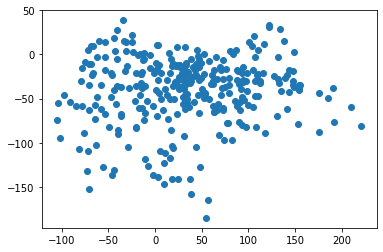

In [142]:
plt.scatter(local_camera_east,local_camera_north)

In [143]:
world_camera_east= local_camera_east + cameracentres.easting[0]
world_camera_east

0      547259.908930
1      547260.715612
2      547261.246936
3      547261.152900
4      547261.194392
           ...      
310    547205.772072
311    547215.195720
312    547314.896808
313    547363.184932
314    547376.848128
Name: easting, Length: 315, dtype: float64

In [144]:
world_camera_north= local_camera_north + cameracentres.northing[0]
world_camera_north

0      9.310845e+06
1      9.310844e+06
2      9.310844e+06
3      9.310844e+06
4      9.310844e+06
           ...     
310    9.310844e+06
311    9.310835e+06
312    9.310830e+06
313    9.310832e+06
314    9.310833e+06
Name: northing, Length: 315, dtype: float64

In [145]:
cameracentres_out = np.column_stack((world_camera_east.values, world_camera_north.values))

In [148]:
outfilename = "/mnt/documents/ANAFI-USA/jc2-2/02092021-jc2-2-p8/mapping-images/driftcorrected_utm_east_north.txt"

In [149]:
np.savetxt(outfilename, cameracentres_out, fmt='%.5f')

That's it! The new trajectory is saved, and now we can use it make LiDAR points in the same coordinate
system as the UAV.